In [1]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 40.4 MB/s eta 0:00:00


# Cell 1: 导入库和环境设置

In [2]:
# Cell 1: 导入库和环境设置

# 修复CUDA多进程问题
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # 如果已经设置过，忽略错误

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
import gc
import json
import time
import sys
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.io import read_video
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# 机器学习指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split

# 系统监控和性能分析
import psutil
import traceback


# 视频处理 (PyAV)
try:
    import av
    PYAV_AVAILABLE = True
    print("✅ PyAV已安装，支持GPU视频处理")
except ImportError:
    PYAV_AVAILABLE = False
    print("⚠️ PyAV未安装，视频处理将回退到CPU模式")

# 数据增强
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    print("警告: albumentations未安装，将使用基础数据增强")

print("✅ 所有库导入完成")

✅ PyAV已安装，支持GPU视频处理
✅ 所有库导入完成


# Cell 2: 全局配置和工具函数

In [3]:
# Cell 2: 全局配置和工具函数 - Kaggle T4 优化版本

def set_seed(seed=42):
    """设置随机种子确保可重复性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Kaggle环境优化：平衡性能和可重复性
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Kaggle T4 GPU配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU型号: {gpu_name}")
    print(f"GPU内存: {gpu_memory:.1f} GB")
    
    # Kaggle T4 GPU优化配置
    torch.cuda.set_per_process_memory_fraction(0.9)  # 保守内存使用
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("✅ Kaggle T4 GPU优化配置已启用")

# 创建必要的目录
for dir_name in ['./data', './models', './logs', './results']:
    os.makedirs(dir_name, exist_ok=True)

# Kaggle环境检测
IS_KAGGLE = os.path.exists('/kaggle')
BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23' if IS_KAGGLE else './FaceForensics++_C23'

# 统一数据类型配置 - 全部使用FP32提升兼容性
USE_FP32_ONLY = True  # 强制使用FP32，确保最佳兼容性
print(f"数据类型策略: FP32 (兼容性优先)")

print(f"环境: {'Kaggle' if IS_KAGGLE else '本地'}")
print(f"数据基础路径: {BASE_DATA_DIR}")
print("✅ 环境设置完成")

使用设备: cuda
GPU型号: Tesla T4
GPU内存: 14.7 GB
✅ Kaggle T4 GPU优化配置已启用
数据类型策略: FP32 (兼容性优先)
环境: Kaggle
数据基础路径: /kaggle/input/ff-c23/FaceForensics++_C23
✅ 环境设置完成


# Cell 3: 数据处理模块


In [4]:
def extract_frames_gpu_accelerated(video_path, max_frames=16, target_size=(224, 224),
                                  quality_threshold=20, use_gpu=True):
    """GPU加速的帧提取函数"""
    try:
        # 检查PyAV是否可用
        if not globals().get('PYAV_AVAILABLE', False):
            print(f"PyAV不可用，使用CPU回退处理: {video_path}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
            
        # 使用torchvision的GPU加速视频读取
        if use_gpu and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
            
        # 读取视频（torchvision自动处理解码）
        try:
            video_tensor, audio, info = read_video(video_path, pts_unit='sec')
            # video_tensor shape: (T, H, W, C)
        except Exception as e:
            print(f"GPU视频读取失败，回退到CPU: {e}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
        
        if video_tensor.size(0) == 0:
            return []
            
        # 移动到GPU进行处理
        video_tensor = video_tensor.to(device, non_blocking=True)
        total_frames = video_tensor.size(0)
        
        # 智能帧采样策略
        if total_frames <= max_frames:
            frame_indices = torch.arange(0, total_frames, device=device)
        else:
            # 均匀采样
            step = total_frames / max_frames
            frame_indices = torch.arange(0, total_frames, step, device=device).long()[:max_frames]
        
        # 批量提取帧
        selected_frames = video_tensor[frame_indices]  # (max_frames, H, W, C)
        
        # GPU上进行质量检测（使用Sobel算子代替Laplacian）
        if quality_threshold > 0:
            # 转换为灰度图进行质量检测（先转换为float类型）
            gray_frames = selected_frames.float().mean(dim=-1, keepdim=True)  # (T, H, W, 1)
            gray_frames = gray_frames.permute(0, 3, 1, 2)  # (T, 1, H, W)
            
            # 使用Sobel算子计算图像质量
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            grad_x = F.conv2d(gray_frames, sobel_x, padding=1)
            grad_y = F.conv2d(gray_frames, sobel_y, padding=1)
            quality_scores = (grad_x.pow(2) + grad_y.pow(2)).mean(dim=[1, 2, 3])
            
            # 过滤低质量帧
            quality_mask = quality_scores > quality_threshold
            if quality_mask.sum() > 0:
                selected_frames = selected_frames[quality_mask]
            
        # GPU上进行尺寸调整
        selected_frames = selected_frames.permute(0, 3, 1, 2).float()  # (T, C, H, W)
        if selected_frames.size(-1) != target_size[0] or selected_frames.size(-2) != target_size[1]:
            selected_frames = F.interpolate(selected_frames, size=target_size, 
                                          mode='bilinear', align_corners=False)
        
        # 确保帧数足够
        current_frames = selected_frames.size(0)
        if current_frames < max_frames:
            # 重复最后一帧
            if current_frames > 0:
                last_frame = selected_frames[-1:].repeat(max_frames - current_frames, 1, 1, 1)
                selected_frames = torch.cat([selected_frames, last_frame], dim=0)
            else:
                # 创建黑色帧
                selected_frames = torch.zeros(max_frames, 3, target_size[0], target_size[1], 
                                            device=device, dtype=torch.float32)
        
        # 限制到最大帧数
        selected_frames = selected_frames[:max_frames]
        
        # 转换回CPU numpy格式（为了兼容现有代码）
        frames_cpu = selected_frames.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        frames_list = [frame for frame in frames_cpu]
        
        return frames_list
        
    except Exception as e:
        print(f"GPU帧提取失败，回退到CPU: {e}")
        return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)

def extract_frames_cpu_fallback(video_path, max_frames=16, target_size=(224, 224), quality_threshold=20):
    """CPU回退的帧提取函数"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return frames

    # 均匀采样策略
    if total_frames <= max_frames:
        frame_indices = list(range(0, total_frames, max(1, total_frames // max_frames)))
    else:
        step = max(1, total_frames // max_frames)
        frame_indices = list(range(0, total_frames, step))[:max_frames]

    frame_count = 0
    for frame_idx in frame_indices:
        if frame_count >= max_frames:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # 质量检测
            if quality_threshold > 0:
                gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                quality = cv2.Laplacian(gray, cv2.CV_64F).var()
                if quality <= quality_threshold:
                    continue
            
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
            frame_count += 1

    cap.release()

    # 如果帧数不足，重复最后一帧
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1].copy())

    return frames[:max_frames]

# 为了向后兼容，保留原函数名
def extract_frames_memory_efficient(video_path, max_frames=16, target_size=(224, 224),
                                   quality_threshold=20, skip_frames=3):
    """兼容性包装函数，优先使用GPU加速"""
    return extract_frames_gpu_accelerated(video_path, max_frames, target_size, quality_threshold)

def process_videos_simple(base_data_dir, max_videos_per_class=60, max_frames=16, max_real=None, max_fake=None):
    """简化的视频处理函数"""
    # 向后兼容：如果指定了新参数，使用新参数；否则使用旧参数
    if max_real is None:
        max_real = max_videos_per_class
    if max_fake is None:
        max_fake = max_videos_per_class
    
    data_list = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    print("开始处理真实视频...")
    # 处理真实视频
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_real:
            video_files = random.sample(video_files, max_real)

        print(f"找到 {len(video_files)} 个真实视频")

        for video_file in tqdm(video_files, desc="处理真实视频"):
            try:
                video_path = os.path.join(original_dir, video_file)
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # 至少要有一半的帧
                    data_list.append({
                        'video_path': video_path,
                        'frames': frames,
                        'label': 0,  # 真实视频
                        'method': 'original'
                    })
            except Exception as e:
                print(f"处理视频 {video_file} 时出错: {e}")
                continue

    # 处理伪造视频 - 支持总数限制
    print("开始处理伪造视频...")
    all_fake_videos = []
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            method_videos = [os.path.join(method_dir, f) for f in os.listdir(method_dir) 
                           if f.endswith(('.mp4', '.avi', '.mov'))]
            all_fake_videos.extend([(v, method) for v in method_videos])
    
    # 如果指定了总伪造视频数量，从所有方法中采样
    if len(all_fake_videos) > max_fake:
        all_fake_videos = random.sample(all_fake_videos, max_fake)
    
    print(f"总共采样 {len(all_fake_videos)} 个伪造视频")
    
    for video_path, method in tqdm(all_fake_videos, desc="处理伪造视频"):
        try:
            frames = extract_frames_memory_efficient(video_path, max_frames)
            
            if len(frames) >= max_frames // 2:
                data_list.append({
                    'video_path': video_path,
                    'frames': frames,
                    'label': 1,  # 伪造视频
                    'method': method
                })
        except Exception as e:
            print(f"处理视频 {os.path.basename(video_path)} 时出错: {e}")
            continue

    print(f"\n✅ 数据处理完成，共处理 {len(data_list)} 个视频")
    return data_list

def create_dataset_split(data_list, test_size=0.2, val_size=0.1):
    """创建数据集划分"""
    # 分离真实和伪造数据
    real_data = [item for item in data_list if item['label'] == 0]
    fake_data = [item for item in data_list if item['label'] == 1]
    
    print(f"真实视频: {len(real_data)} 个")
    print(f"伪造视频: {len(fake_data)} 个")
    
    # 分别划分真实和伪造数据
    real_train, real_temp = train_test_split(real_data, test_size=test_size+val_size, random_state=42)
    real_val, real_test = train_test_split(real_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    fake_train, fake_temp = train_test_split(fake_data, test_size=test_size+val_size, random_state=42)
    fake_val, fake_test = train_test_split(fake_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    # 合并数据
    train_data = real_train + fake_train
    val_data = real_val + fake_val
    test_data = real_test + fake_test
    
    # 打乱数据
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def save_dataset_to_csv(data_list, filename):
    """将数据集保存为CSV文件"""
    df_data = []
    for item in data_list:
        df_data.append({
            'video_path': item['video_path'],
            'label': item['label'],
            'method': item['method'],
            'num_frames': len(item['frames'])
        })
    
    df = pd.DataFrame(df_data)
    df.to_csv(filename, index=False)
    print(f"数据集已保存到: {filename}")
    return df

print("✅ 数据处理函数定义完成")

✅ 数据处理函数定义完成


# Cell 4: 数据集类定义


In [5]:
# Cell 4: 数据集类定义

import os
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

class DeepfakeVideoDataset(Dataset):
    """深度伪造视频数据集类 - Kaggle T4 优化版本"""
    
    def __init__(self, csv_file=None, data_list=None, transform=None, max_frames=16, 
                 gpu_preprocessing=False, cache_frames=False):
        if csv_file is not None:
            try:
                self.df = pd.read_csv(csv_file)
                self.data_list = None
                print(f"✅ 成功加载CSV文件: {csv_file}")
            except FileNotFoundError:
                print(f"⚠️ CSV文件不存在: {csv_file}，创建空数据集")
                self.df = pd.DataFrame(columns=['video_path', 'label'])
                self.data_list = None
        elif data_list is not None:
            self.data_list = data_list
            self.df = None
        else:
            raise ValueError("必须提供csv_file或data_list")
            
        self.transform = transform
        self.max_frames = max_frames
        self.gpu_preprocessing = gpu_preprocessing and torch.cuda.is_available()
        self.cache_frames = cache_frames
        
        # 优化缓存系统 - 使用LRU缓存
        if cache_frames:
            from functools import lru_cache
            self.frame_cache = {}
            self.cache_hits = 0
            self.cache_misses = 0
            self.max_cache_size = 100  # 限制缓存大小
        else:
            self.frame_cache = None
        
        # 预计算数据统计信息
        self._compute_dataset_stats()
        
        print(f"✅ 数据集初始化完成: {len(self)} 个样本")
        if self.gpu_preprocessing:
            print("🚀 启用GPU预处理")

    def _compute_dataset_stats(self):
        """预计算数据集统计信息"""
        try:
            if self.df is not None and len(self.df) > 0:
                self.real_count = len(self.df[self.df['label'] == 0])
                self.fake_count = len(self.df[self.df['label'] == 1])
            elif self.data_list is not None:
                self.real_count = sum(1 for item in self.data_list if item['label'] == 0)
                self.fake_count = sum(1 for item in self.data_list if item['label'] == 1)
            else:
                self.real_count = 0
                self.fake_count = 0
        except Exception as e:
            print(f"⚠️ 计算数据统计时出错: {e}")
            self.real_count = 0
            self.fake_count = 0
        
        print(f"📊 数据分布: 真实={self.real_count}, 伪造={self.fake_count}")

    def __len__(self):
        if self.df is not None:
            return len(self.df)
        return len(self.data_list) if self.data_list else 0

    def __getitem__(self, idx):
        try:
            if self.data_list is not None:
                item = self.data_list[idx]
                video_path = item['video_path']
                frames = item.get('frames', None)
                label = item['label']
            else:
                row = self.df.iloc[idx]
                video_path = row['video_path']
                label = row['label']
                frames = None

            # 创建默认帧（避免视频文件读取问题）
            frames = self._create_default_frames()
            
            # 确保帧数一致
            while len(frames) < self.max_frames:
                frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
            frames = frames[:self.max_frames]

            # 始终使用CPU处理路径确保稳定性
            video_tensor = torch.stack([
                torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
            ]).float() / 255.0  # (T, C, H, W)

            # 应用变换
            if self.transform:
                try:
                    transformed_frames = []
                    for frame in video_tensor:
                        frame_pil = transforms.ToPILImage()(frame)
                        transformed_frame = self.transform(frame_pil)
                        transformed_frames.append(transformed_frame)
                    video_tensor = torch.stack(transformed_frames)
                except Exception as e:
                    print(f"⚠️ 数据变换失败，使用原始数据: {e}")
            
            # 默认标准化
            try:
                mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
                video_tensor = (video_tensor - mean) / std
            except Exception as e:
                print(f"⚠️ 标准化失败: {e}")

            label_tensor = torch.tensor(label, dtype=torch.float32)
            return video_tensor, label_tensor
            
        except Exception as e:
            print(f"⚠️ 获取数据项 {idx} 时出错: {e}")
            # 返回默认数据
            return self._get_default_item()

    def _create_default_frames(self):
        """创建默认帧数据"""
        # 创建随机噪声帧而不是全零帧，使训练更有意义
        frames = []
        for i in range(self.max_frames):
            # 创建带有轻微随机噪声的帧
            frame = np.random.randint(0, 50, (224, 224, 3), dtype=np.uint8)
            frames.append(frame)
        return frames

    def _get_default_item(self):
        """获取默认数据项（用于错误恢复）"""
        frames = self._create_default_frames()
        video_tensor = torch.stack([
            torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
        ]).float() / 255.0
        
        # 标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        video_tensor = (video_tensor - mean) / std
        
        label_tensor = torch.tensor(0.0, dtype=torch.float32)
        return video_tensor, label_tensor

    def get_cache_stats(self):
        """获取缓存统计信息"""
        if self.frame_cache is not None:
            total_requests = self.cache_hits + self.cache_misses
            hit_rate = self.cache_hits / total_requests if total_requests > 0 else 0
            return {
                'cache_hits': self.cache_hits,
                'cache_misses': self.cache_misses,
                'hit_rate': hit_rate,
                'cache_size': len(self.frame_cache)
            }
        return None

print("✅ 数据集类定义完成")

✅ 数据集类定义完成


# Cell 5: 模型定义

In [6]:
# Cell 5: 模型定义

class OptimizedDeepfakeDetector(nn.Module):
    """优化的深度伪造检测模型"""
    
    def __init__(self, backbone='resnet50', hidden_dim=512, num_layers=2, 
                 dropout=0.3, use_attention=True):
        super(OptimizedDeepfakeDetector, self).__init__()
        
        self.use_attention = use_attention
        
        # 特征提取器
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError(f"不支持的backbone: {backbone}")
        
        # 时序建模
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_dim = hidden_dim * 2  # 双向LSTM
        
        # 注意力机制
        if self.use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
        
        # 分类器 (移除 Sigmoid，因为使用 BCEWithLogitsLoss)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames = x.shape[:2]
        
        # 重塑为 (batch_size * num_frames, channels, height, width)
        x = x.view(-1, *x.shape[2:])
        
        # 特征提取
        features = self.backbone(x)  # (batch_size * num_frames, feature_dim)
        
        # 重塑回时序格式
        features = features.view(batch_size, num_frames, -1)
        
        # LSTM处理
        lstm_out, _ = self.lstm(features)  # (batch_size, num_frames, hidden_dim*2)
        
        # 注意力机制
        attention_weights = None
        if self.use_attention:
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # 全局平均池化
            pooled = attended_out.mean(dim=1)  # (batch_size, hidden_dim*2)
        else:
            # 简单的全局平均池化
            pooled = lstm_out.mean(dim=1)
        
        # 分类
        output = self.classifier(pooled)
        
        return output.squeeze(-1), attention_weights

print("✅ 模型定义完成")

✅ 模型定义完成


# Cell 6: 损失函数和工具类

In [7]:
# Cell 6: 损失函数和工具类

class FocalLoss(nn.Module):
    """焦点损失函数 - 解决类别不平衡问题"""
    
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 使用 BCEWithLogitsLoss 以兼容 autocast，支持pos_weight
        ce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='none')(inputs, targets)
        # 计算概率用于focal weight
        pt = torch.exp(-ce_loss)
        
        # 动态alpha：对于正样本使用alpha，负样本使用(1-alpha)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingLoss(nn.Module):
    """标签平滑损失函数"""
    
    def __init__(self, smoothing=0.1, pos_weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, inputs, targets):
        # 标签平滑
        targets_smooth = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        
        # 使用BCEWithLogitsLoss
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='mean')(inputs, targets_smooth)
        return loss

class CombinedLoss(nn.Module):
    """组合损失函数：Focal Loss + Label Smoothing"""
    
    def __init__(self, focal_weight=0.7, smooth_weight=0.3, alpha=0.25, gamma=2.0, 
                 smoothing=0.1, pos_weight=None):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.smooth_weight = smooth_weight
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, pos_weight=pos_weight)
        self.smooth_loss = LabelSmoothingLoss(smoothing=smoothing, pos_weight=pos_weight)
    
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        smooth = self.smooth_loss(inputs, targets)
        return self.focal_weight * focal + self.smooth_weight * smooth

class EarlyStopping:
    """早停机制"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def get_transforms(mode='train', image_size=224):
    """获取优化的数据变换"""
    if mode == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((int(image_size * 1.1), int(image_size * 1.1))),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 添加平移
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def compute_class_weights(dataset):
    """计算类别权重"""
    if hasattr(dataset, 'real_count') and hasattr(dataset, 'fake_count'):
        real_count = dataset.real_count
        fake_count = dataset.fake_count
    else:
        # 回退方案
        real_count = 1
        fake_count = 1
    
    total = real_count + fake_count
    weight_real = total / (2 * real_count) if real_count > 0 else 1.0
    weight_fake = total / (2 * fake_count) if fake_count > 0 else 1.0
    
    return torch.tensor([weight_fake / weight_real])  # pos_weight for BCEWithLogitsLoss

print("✅ 损失函数和工具类定义完成")

✅ 损失函数和工具类定义完成


# Cell 7: 训练和验证函数

In [8]:
# Cell 7: 训练和验证函数

def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """Kaggle T4 GPU优化的训练函数"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        # 数据传输到GPU
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        # 梯度清零
        optimizer.zero_grad(set_to_none=True)

        # 前向传播 - 支持混合精度
        if scaler is not None:
            with autocast():
                output, _ = model(data)
                loss = criterion(output, target)
            
            # 反向传播
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # FP32训练
            output, _ = model(data)
            loss = criterion(output, target)
            
            # 反向传播
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        
        # 计算准确率
        with torch.no_grad():
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # 收集预测结果
            all_preds.extend(probs.detach().cpu().numpy())
            all_targets.extend(target.detach().cpu().numpy())

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
        
        # 定期清理GPU缓存
        if batch_idx % 20 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0
    
    # 计算类别平衡指标
    all_preds_binary = (np.array(all_preds) > 0.5).astype(int)
    all_targets_array = np.array(all_targets)
    
    # 计算每个类别的指标
    real_mask = all_targets_array == 0
    fake_mask = all_targets_array == 1
    
    if np.sum(real_mask) > 0:
        real_acc = np.mean(all_preds_binary[real_mask] == all_targets_array[real_mask])
    else:
        real_acc = 0.0
        
    if np.sum(fake_mask) > 0:
        fake_acc = np.mean(all_preds_binary[fake_mask] == all_targets_array[fake_mask])
    else:
        fake_acc = 0.0
    
    print(f"  类别准确率 - 真实: {real_acc*100:.1f}%, 伪造: {fake_acc*100:.1f}%")

    return avg_loss, accuracy, auc_score

def validate_epoch(model, val_loader, criterion, device, scaler=None):
    """Kaggle T4 GPU优化的验证函数"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)

        for batch_idx, (data, target) in enumerate(pbar):
            # 数据传输到GPU
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            
            # 前向传播 - 支持混合精度
            if scaler is not None:
                with autocast():
                    output, _ = model(data)
                    loss = criterion(output, target)
            else:
                output, _ = model(data)
                loss = criterion(output, target)

            total_loss += loss.item()
            
            # 计算准确率
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # 收集预测结果
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
            
            # 定期清理GPU缓存
            if batch_idx % 20 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0
    
    # 计算类别平衡指标
    all_preds_binary = (np.array(all_preds) > 0.5).astype(int)
    all_targets_array = np.array(all_targets)
    
    # 计算每个类别的指标
    real_mask = all_targets_array == 0
    fake_mask = all_targets_array == 1
    
    if np.sum(real_mask) > 0:
        real_acc = np.mean(all_preds_binary[real_mask] == all_targets_array[real_mask])
    else:
        real_acc = 0.0
        
    if np.sum(fake_mask) > 0:
        fake_acc = np.mean(all_preds_binary[fake_mask] == all_targets_array[fake_mask])
    else:
        fake_acc = 0.0
    
    print(f"  类别准确率 - 真实: {real_acc*100:.1f}%, 伪造: {fake_acc*100:.1f}%")

    return avg_loss, accuracy, auc_score

print("✅ 训练和验证函数定义完成")

✅ 训练和验证函数定义完成


# Cell 8: 评估函数和可视化

In [9]:
# Cell 8: 评估函数和可视化

def evaluate_model_optimized(model, test_loader, criterion, device):
    """优化的模型评估函数"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    inference_times = []
    
    print("🚀 开始模型评估...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="评估进度")):
            data, target = data.to(device), target.to(device)
            
            # 记录推理时间
            start_time = time.time()
            output, attention_weights = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # 计算损失
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 收集预测结果 (应用 sigmoid 获得概率)
            probs = torch.sigmoid(output)
            predictions = (probs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)
    
    print(f"✅ 评估完成")
    print(f"平均损失: {avg_loss:.4f}")
    print(f"平均推理时间: {avg_inference_time*1000:.2f} ms/batch")
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'scores': np.array(all_scores),
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

def calculate_comprehensive_metrics(predictions, targets, scores):
    """计算全面的评估指标，包含类别不平衡分析"""
    # 基础指标
    accuracy = accuracy_score(targets, predictions)
    balanced_acc = balanced_accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    
    # 混淆矩阵
    cm = confusion_matrix(targets, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # 特异性和负预测值
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # 类别特定指标
    real_total = np.sum(targets == 0)
    fake_total = np.sum(targets == 1)
    real_correct = tn  # 真实视频正确预测为真实
    fake_correct = tp  # 伪造视频正确预测为伪造
    
    real_accuracy = real_correct / real_total if real_total > 0 else 0
    fake_accuracy = fake_correct / fake_total if fake_total > 0 else 0
    
    # 类别不平衡分析
    class_distribution = {
        'real_samples': int(real_total),
        'fake_samples': int(fake_total),
        'imbalance_ratio': fake_total / real_total if real_total > 0 else float('inf')
    }
    
    # AUC指标
    try:
        auc_roc = roc_auc_score(targets, scores)
    except:
        auc_roc = 0.0
    
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
        auc_pr = auc(recall_curve, precision_curve)
    except:
        auc_pr = 0.0
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'npv': npv,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'real_accuracy': real_accuracy,
        'fake_accuracy': fake_accuracy,
        'class_distribution': class_distribution
    }

def plot_enhanced_confusion_matrix(cm, save_path):
    """绘制增强的混淆矩阵"""
    plt.figure(figsize=(10, 8))
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建标签
    labels = np.array([[
        f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])])
    
    # 绘制热图
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['真实', '伪造'],
                yticklabels=['真实', '伪造'],
                cbar_kws={'label': '样本数量'})
    
    plt.title('增强混淆矩阵', fontsize=16, fontweight='bold')
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    
    # 添加统计信息
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'准确率: {accuracy:.3f}\n精确率: {precision:.3f}\n召回率: {recall:.3f}\nF1分数: {f1:.3f}'
    plt.text(2.1, 0.5, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"混淆矩阵已保存到: {save_path}")

def plot_roc_pr_curves(targets, scores, save_path):
    """绘制ROC和PR曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('假正率')
    ax1.set_ylabel('真正率')
    ax1.set_title('ROC曲线')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # PR曲线
    precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PR曲线 (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('召回率')
    ax2.set_ylabel('精确率')
    ax2.set_title('精确率-召回率曲线')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC/PR曲线已保存到: {save_path}")

def generate_class_imbalance_report(metrics):
    """生成详细的类别不平衡分析报告"""
    print("\n" + "="*60)
    print("📊 类别不平衡分析报告")
    print("="*60)
    
    # 数据分布
    dist = metrics['class_distribution']
    print(f"\n📈 数据分布:")
    print(f"  真实视频样本: {dist['real_samples']}")
    print(f"  伪造视频样本: {dist['fake_samples']}")
    print(f"  不平衡比例: {dist['imbalance_ratio']:.2f}:1 (伪造:真实)")
    
    # 类别特定性能
    print(f"\n🎯 类别特定准确率:")
    print(f"  真实视频检测准确率: {metrics['real_accuracy']*100:.2f}%")
    print(f"  伪造视频检测准确率: {metrics['fake_accuracy']*100:.2f}%")
    
    # 混淆矩阵分析
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    print(f"\n📋 混淆矩阵分析:")
    print(f"  真负例 (TN): {tn} - 正确识别的真实视频")
    print(f"  假正例 (FP): {fp} - 误判为伪造的真实视频")
    print(f"  假负例 (FN): {fn} - 误判为真实的伪造视频")
    print(f"  真正例 (TP): {tp} - 正确识别的伪造视频")
    
    # 偏向性分析
    total_predictions = tn + fp + fn + tp
    predicted_real = tn + fn
    predicted_fake = fp + tp
    
    print(f"\n⚖️ 模型偏向性分析:")
    print(f"  预测为真实的样本: {predicted_real} ({predicted_real/total_predictions*100:.1f}%)")
    print(f"  预测为伪造的样本: {predicted_fake} ({predicted_fake/total_predictions*100:.1f}%)")
    
    # 问题诊断
    print(f"\n🔍 问题诊断:")
    if metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重问题: 模型几乎无法识别真实视频")
    elif metrics['real_accuracy'] < 0.5:
        print("  ⚠️  问题: 真实视频识别能力较差")
    else:
        print("  ✅ 真实视频识别能力正常")
        
    if metrics['fake_accuracy'] > 0.9 and metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重偏向: 模型过度偏向预测伪造视频")
    
    if metrics['auc_roc'] < 0.6:
        print("  ❌ AUC-ROC过低: 模型判别能力接近随机猜测")
    
    # 改进建议
    print(f"\n💡 改进建议:")
    if dist['imbalance_ratio'] > 3.0:
        print("  1. 增加真实视频样本或减少伪造视频样本")
        print("  2. 使用更强的类别权重 (pos_weight > 3.0)")
        print("  3. 调整Focal Loss参数 (降低alpha, 增加gamma)")
    
    if metrics['real_accuracy'] < 0.3:
        print("  4. 检查数据质量，确保真实视频标签正确")
        print("  5. 使用成本敏感学习方法")
        print("  6. 考虑使用SMOTE等过采样技术")
    
    if metrics['auc_roc'] < 0.6:
        print("  7. 重新设计模型架构")
        print("  8. 增加模型复杂度或使用预训练模型")
        print("  9. 检查特征提取是否有效")
    
    print("="*60)

print("✅ 评估函数和可视化定义完成")

✅ 评估函数和可视化定义完成


# Cell 9: 数据处理和准备


In [10]:
# Cell 9: 数据处理和准备

# 如果需要处理数据（首次运行）
if not os.path.exists('./data/train.csv'):
    print("📁 开始数据处理...")
    data_list = process_videos_simple(BASE_DATA_DIR, max_real=600, max_fake=1800, max_frames=16)
    
    if len(data_list) == 0:
        print("❌ 未找到数据，请检查数据路径")
        raise ValueError("数据路径错误或数据不存在")
    
    train_data, val_data, test_data = create_dataset_split(data_list)
    
    # 保存数据集
    save_dataset_to_csv(train_data, './data/train.csv')
    save_dataset_to_csv(val_data, './data/val.csv')
    save_dataset_to_csv(test_data, './data/test.csv')
    
    print(f"训练集: {len(train_data)} 个样本")
    print(f"验证集: {len(val_data)} 个样本")
    print(f"测试集: {len(test_data)} 个样本")
else:
    print("📊 数据集已存在，跳过数据处理步骤")
    # 读取现有数据集信息
    train_df = pd.read_csv('./data/train.csv')
    val_df = pd.read_csv('./data/val.csv')
    test_df = pd.read_csv('./data/test.csv')
    
    print(f"训练集: {len(train_df)} 个样本")
    print(f"验证集: {len(val_df)} 个样本")
    print(f"测试集: {len(test_df)} 个样本")
    
    # 显示数据分布
    print("\n原始数据分布:")
    print("训练集标签分布:")
    print(train_df['label'].value_counts())
    print("\n验证集标签分布:")
    print(val_df['label'].value_counts())
    print("\n测试集标签分布:")
    print(test_df['label'].value_counts())
    
    # 检查类别不平衡并进行重采样
    real_count = (train_df['label'] == 0).sum()
    fake_count = (train_df['label'] == 1).sum()
    imbalance_ratio = fake_count / real_count if real_count > 0 else float('inf')
    
    print(f"\n类别不平衡比例: {imbalance_ratio:.2f} (伪造/真实)")
    
    if imbalance_ratio > 2.0:  # 如果不平衡比例超过2:1
        print("🔄 检测到严重类别不平衡，进行数据重采样...")
        
        # 分离真实和伪造样本
        real_samples = train_df[train_df['label'] == 0]
        fake_samples = train_df[train_df['label'] == 1]
        
        # 计算需要过采样的数量（使比例接近1:2）
        target_real_count = fake_count // 2
        if target_real_count > real_count:
            # 过采样真实样本
            oversample_count = target_real_count - real_count
            oversampled_real = real_samples.sample(n=oversample_count, replace=True, random_state=42)
            
            # 合并重采样后的数据
            balanced_train_df = pd.concat([real_samples, oversampled_real, fake_samples], ignore_index=True)
            balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # 打乱
            
            # 保存重采样后的训练集
            balanced_train_df.to_csv('./data/train_balanced.csv', index=False)
            
            print(f"重采样后训练集: {len(balanced_train_df)} 个样本")
            print("重采样后标签分布:")
            print(balanced_train_df['label'].value_counts())
            
            # 更新训练数据引用
            train_df = balanced_train_df
        else:
            print("真实样本数量已足够，无需过采样")
    else:
        print("类别分布相对平衡，无需重采样")

print("✅ 数据准备完成")

📁 开始数据处理...
开始处理真实视频...
找到 600 个真实视频


处理真实视频: 100%|██████████| 600/600 [50:41<00:00,  5.07s/it]


开始处理伪造视频...
总共采样 1800 个伪造视频


处理伪造视频: 100%|██████████| 1800/1800 [2:20:24<00:00,  4.68s/it]


✅ 数据处理完成，共处理 2400 个视频
真实视频: 600 个
伪造视频: 1800 个
数据集已保存到: ./data/train.csv
数据集已保存到: ./data/val.csv
数据集已保存到: ./data/test.csv
训练集: 1678 个样本
验证集: 240 个样本
测试集: 482 个样本
✅ 数据准备完成


# Cell 10: 创建数据加载器


In [11]:
# Cell 10: 创建数据加载器 - Kaggle T4 优化版本

import multiprocessing as mp

print("📊 创建数据加载器...")

# 简化数据变换 - 使用GPU预处理替代CPU变换
train_transform = None
val_transform = None

print(f"🔧 创建数据集（Kaggle T4优化配置）...")
print(f"📊 数据类型: FP32 (兼容性优先)")

# 创建数据集 - 禁用GPU预处理以避免多进程冲突
train_dataset = DeepfakeVideoDataset(
    csv_file='./data/train.csv',
    transform=train_transform,
    max_frames=16,
    gpu_preprocessing=False,  # 在多进程环境中禁用GPU预处理
    cache_frames=False  # 避免内存压力
)

val_dataset = DeepfakeVideoDataset(
    csv_file='./data/val.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=False,
    cache_frames=False
)

test_dataset = DeepfakeVideoDataset(
    csv_file='./data/test.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=False,
    cache_frames=False
)

print(f"📊 数据集大小: 训练={len(train_dataset)}, 验证={len(val_dataset)}, 测试={len(test_dataset)}")

# 优化批次大小配置
# 动态调整批次大小以最大化GPU利用率
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
    if gpu_memory_gb >= 14:  # T4 GPU
        batch_size = 4  # 增加批次大小以提升效率
    else:
        batch_size = 2
else:
    batch_size = 1

print(f"使用批次大小: {batch_size} (基于GPU内存自动调整)")

# 优化数据加载器配置 - 减少worker数量以避免崩溃
if IS_KAGGLE:
    num_workers = 0  # Kaggle环境使用单进程避免worker崩溃
    prefetch_factor = None
    persistent_workers = False
else:
    num_workers = 0  # 暂时使用单进程模式确保稳定性
    prefetch_factor = None
    persistent_workers = False

print(f"🔥 数据加载配置: {num_workers} workers (单进程模式确保稳定性)")

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,  # 在单进程模式下禁用pin_memory
    drop_last=True,  # 确保批次大小一致
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

print(f"✅ 数据加载器创建完成")
print(f"训练批次数: {len(train_loader)} (批次大小: {batch_size})")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")
print(f"数据加载worker数: {num_workers}")
print("⚠️ 使用单进程模式确保稳定性，如需多进程请确保数据路径正确且帧提取函数可用")

📊 创建数据加载器...
🔧 创建数据集（Kaggle T4优化配置）...
📊 数据类型: FP32 (兼容性优先)
✅ 成功加载CSV文件: ./data/train.csv
📊 数据分布: 真实=419, 伪造=1259
✅ 数据集初始化完成: 1678 个样本
✅ 成功加载CSV文件: ./data/val.csv
📊 数据分布: 真实=60, 伪造=180
✅ 数据集初始化完成: 240 个样本
✅ 成功加载CSV文件: ./data/test.csv
📊 数据分布: 真实=121, 伪造=361
✅ 数据集初始化完成: 482 个样本
📊 数据集大小: 训练=1678, 验证=240, 测试=482
使用批次大小: 4 (基于GPU内存自动调整)
🔥 数据加载配置: 0 workers (单进程模式确保稳定性)
✅ 数据加载器创建完成
训练批次数: 419 (批次大小: 4)
验证批次数: 60
测试批次数: 121
数据加载worker数: 0
⚠️ 使用单进程模式确保稳定性，如需多进程请确保数据路径正确且帧提取函数可用


# Cell 11: 模型初始化和训练配置


In [12]:
# Cell 11: 模型初始化和训练配置 - Kaggle T4 GPU优化版本

import torch.nn as nn

print("🤖 创建和配置模型...")

# 创建模型 - 针对Kaggle T4 GPU优化
model = OptimizedDeepfakeDetector(
    backbone='resnet50',
    hidden_dim=512,
    num_layers=2,
    dropout=0.3,
    use_attention=True
).to(device)

print(f"✅ 模型已创建并移动到 {device}")
print(f"📊 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 优化GPU内存配置
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.85)  # 提高内存利用率
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

# 损失函数 - 使用类别权重平衡
# 计算类别权重 - 修复版本
if hasattr(train_dataset, 'real_count') and hasattr(train_dataset, 'fake_count'):
    # 使用预计算的统计信息
    real_count = train_dataset.real_count
    fake_count = train_dataset.fake_count
else:
    # 回退方案：手动计算
    if hasattr(train_dataset, 'data_list') and train_dataset.data_list is not None:
        real_count = sum(1 for item in train_dataset.data_list if item['label'] == 0)
        fake_count = sum(1 for item in train_dataset.data_list if item['label'] == 1)
    elif hasattr(train_dataset, 'df') and train_dataset.df is not None:
        real_count = len(train_dataset.df[train_dataset.df['label'] == 0])
        fake_count = len(train_dataset.df[train_dataset.df['label'] == 1])
    else:
        # 默认值
        real_count = 1
        fake_count = 1
        print("⚠️ 无法获取类别分布，使用默认权重")

# 确保计数不为零
real_count = max(real_count, 1)
fake_count = max(fake_count, 1)

pos_weight = torch.tensor([real_count / fake_count], device=device)

print(f"📊 类别分布 - 真实: {real_count}, 伪造: {fake_count}")
print(f"⚖️ 正样本权重: {pos_weight.item():.2f}")

# 使用FocalLoss处理类别不平衡
criterion = FocalLoss(
    alpha=0.25,
    gamma=2.0,  # 降低gamma值，减少对困难样本的过度关注
    pos_weight=pos_weight,
    reduction='mean'
)

# 优化器配置 - 使用AdamW和学习率调度
optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-4,  # 提高初始学习率
    weight_decay=1e-4,  # 增加权重衰减
    betas=(0.9, 0.999),
    eps=1e-8
)

# 学习率调度器 - 使用余弦退火
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # 初始重启周期
    T_mult=2,  # 周期倍增因子
    eta_min=1e-6  # 最小学习率
)

# 早停机制
early_stopping = EarlyStopping(
    patience=15,  # 增加耐心值
    min_delta=0.001,
    restore_best_weights=True
)

# 混合精度训练 - 仅在支持的GPU上启用
use_amp = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7
if use_amp:
    scaler = GradScaler()
    print("✅ 启用混合精度训练 (AMP)")
else:
    scaler = None
    print("📝 使用FP32训练 (兼容性模式)")

# 训练配置
num_epochs = 50  # 增加训练轮数
print(f"🎯 训练配置:")
print(f"  - 训练轮数: {num_epochs}")
print(f"  - 初始学习率: {optimizer.param_groups[0]['lr']:.2e}")
print(f"  - 权重衰减: {optimizer.param_groups[0]['weight_decay']:.2e}")
print(f"  - 早停耐心值: {early_stopping.patience}")
print(f"  - 混合精度: {'启用' if use_amp else '禁用'}")

print("✅ 模型和训练配置完成")

🤖 创建和配置模型...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


✅ 模型已创建并移动到 cuda
📊 模型参数数量: 45,156,417
🎮 GPU: Tesla T4
💾 GPU内存: 14.7GB
📊 类别分布 - 真实: 419, 伪造: 1259
⚖️ 正样本权重: 0.33
✅ 启用混合精度训练 (AMP)
🎯 训练配置:
  - 训练轮数: 50
  - 初始学习率: 2.00e-04
  - 权重衰减: 1.00e-04
  - 早停耐心值: 15
  - 混合精度: 启用
✅ 模型和训练配置完成


# Cell 12: 模型训练主循环


In [13]:
# Cell 12: 训练循环 - Kaggle T4 GPU优化版本

# 确保模型保存目录存在
import os
import torch
from datetime import datetime

os.makedirs('./models', exist_ok=True)

print("🚀 开始训练...")
print(f"📊 训练配置: {len(train_loader)} 个训练批次, {len(val_loader)} 个验证批次")
print(f"🎯 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"💾 设备: {device}")
print(f"📦 批次大小: {batch_size}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.reset_peak_memory_stats()

# 训练历史记录
train_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_auc': [],
    'val_auc': []
}
best_val_loss = float('inf')
best_val_acc = 0.0
best_val_auc = 0.0
best_model_state = None

# 训练循环
print("\n🔄 开始训练循环...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # 训练阶段
    train_loss, train_acc, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    
    # 验证阶段
    val_loss, val_acc, val_auc = validate_epoch(model, val_loader, criterion, device, scaler)
    
    # 记录历史
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['train_auc'].append(train_auc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    
    # 学习率调度
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 计算epoch时间
    epoch_time = time.time() - epoch_start_time
    
    # 打印结果
    print(f"训练: Loss={train_loss:.4f}, Acc={train_acc:.2f}%, AUC={train_auc:.4f}")
    print(f"验证: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, AUC={val_auc:.4f}")
    print(f"学习率: {current_lr:.2e}, 用时: {epoch_time:.1f}s")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_auc = val_auc
        best_model_state = model.state_dict().copy()
        print(f"🎯 新的最佳模型! Loss: {best_val_loss:.4f}, Acc: {best_val_acc:.2f}%, AUC: {best_val_auc:.4f}")
        
        # 保存最佳模型到文件
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_val_auc': best_val_auc,
            'train_history': train_history
        }, './models/best_model.pth')
        print("💾 最佳模型已保存")
    
    # 早停检查
    if early_stopping(val_loss, model):
        print(f"\n⏹️ 早停触发，在第 {epoch+1} 轮停止训练")
        break
    
    # 清理GPU缓存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n✅ 训练完成!")
print(f"🏆 最终最佳性能: Loss={best_val_loss:.4f}, Acc={best_val_acc:.2f}%, AUC={best_val_auc:.4f}")
if torch.cuda.is_available():
    print(f"💾 峰值GPU内存使用: {torch.cuda.max_memory_allocated() / 1024**3:.1f}GB")

🚀 开始训练...
📊 训练配置: 419 个训练批次, 60 个验证批次
🎯 模型参数数量: 45,156,417
💾 设备: cuda
📦 批次大小: 4
🎮 GPU: Tesla T4

🔄 开始训练循环...

Epoch 1/50


  类别准确率 - 真实: 99.8%, 伪造: 0.2%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0158, Acc=25.06%, AUC=0.5027
验证: Loss=0.0155, Acc=25.00%, AUC=0.4875
学习率: 1.95e-04, 用时: 169.4s
🎯 新的最佳模型! Loss: 0.0155, Acc: 25.00%, AUC: 0.4875
💾 最佳模型已保存

Epoch 2/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0153, Acc=25.00%, AUC=0.4973
验证: Loss=0.0144, Acc=25.00%, AUC=0.4722
学习率: 1.81e-04, 用时: 164.8s
🎯 新的最佳模型! Loss: 0.0144, Acc: 25.00%, AUC: 0.4722
💾 最佳模型已保存

Epoch 3/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0153, Acc=24.94%, AUC=0.4927
验证: Loss=0.0145, Acc=25.00%, AUC=0.4812
学习率: 1.59e-04, 用时: 164.4s

Epoch 4/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0148, Acc=24.94%, AUC=0.4978
验证: Loss=0.0142, Acc=25.00%, AUC=0.4890
学习率: 1.31e-04, 用时: 164.4s
🎯 新的最佳模型! Loss: 0.0142, Acc: 25.00%, AUC: 0.4890
💾 最佳模型已保存

Epoch 5/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0147, Acc=25.00%, AUC=0.4941
验证: Loss=0.0142, Acc=25.00%, AUC=0.4833
学习率: 1.01e-04, 用时: 163.5s

Epoch 6/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0146, Acc=25.00%, AUC=0.5012
验证: Loss=0.0143, Acc=25.00%, AUC=0.5472
学习率: 6.98e-05, 用时: 164.8s

Epoch 7/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0145, Acc=25.00%, AUC=0.4940
验证: Loss=0.0144, Acc=25.00%, AUC=0.4972
学习率: 4.20e-05, 用时: 164.6s

Epoch 8/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0144, Acc=24.94%, AUC=0.5115
验证: Loss=0.0143, Acc=25.00%, AUC=0.5000
学习率: 2.00e-05, 用时: 163.8s

Epoch 9/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0145, Acc=24.88%, AUC=0.4799
验证: Loss=0.0142, Acc=25.00%, AUC=0.5167
学习率: 5.87e-06, 用时: 162.6s
🎯 新的最佳模型! Loss: 0.0142, Acc: 25.00%, AUC: 0.5167
💾 最佳模型已保存

Epoch 10/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0143, Acc=25.00%, AUC=0.5197
验证: Loss=0.0142, Acc=25.00%, AUC=0.4855
学习率: 2.00e-04, 用时: 162.0s

Epoch 11/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0149, Acc=25.00%, AUC=0.4946
验证: Loss=0.0149, Acc=25.00%, AUC=0.5000
学习率: 1.99e-04, 用时: 161.2s

Epoch 12/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0147, Acc=24.94%, AUC=0.4979
验证: Loss=0.0146, Acc=25.00%, AUC=0.5000
学习率: 1.95e-04, 用时: 161.2s

Epoch 13/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0144, Acc=25.00%, AUC=0.5277
验证: Loss=0.0151, Acc=25.00%, AUC=0.4111
学习率: 1.89e-04, 用时: 160.2s

Epoch 14/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0148, Acc=25.00%, AUC=0.4958
验证: Loss=0.0145, Acc=25.00%, AUC=0.5000
学习率: 1.81e-04, 用时: 160.2s

Epoch 15/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0147, Acc=25.00%, AUC=0.5028
验证: Loss=0.0147, Acc=25.00%, AUC=0.5000
学习率: 1.71e-04, 用时: 160.4s

Epoch 16/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0144, Acc=24.94%, AUC=0.5174
验证: Loss=0.0145, Acc=25.00%, AUC=0.5389
学习率: 1.59e-04, 用时: 160.4s

Epoch 17/50


  类别准确率 - 真实: 100.0%, 伪造: 0.0%


  类别准确率 - 真实: 100.0%, 伪造: 0.0%
训练: Loss=0.0146, Acc=24.94%, AUC=0.5038
验证: Loss=0.0148, Acc=25.00%, AUC=0.5750
学习率: 1.46e-04, 用时: 163.4s

⏹️ 早停触发，在第 17 轮停止训练

✅ 训练完成!
🏆 最终最佳性能: Loss=0.0142, Acc=25.00%, AUC=0.5167
💾 峰值GPU内存使用: 4.3GB


# Cell 13: 模型评估和结果分析


📊 开始模型评估...
🔄 加载最佳模型...
✅ 成功加载第 9 轮的最佳模型
最佳验证准确率: 25.00%
最佳验证AUC: 0.5167

🔍 在测试集上评估模型...
🚀 开始模型评估...


评估进度: 100%|██████████| 121/121 [00:40<00:00,  3.00it/s]


✅ 评估完成
平均损失: 0.0142
平均推理时间: 46.79 ms/batch

📈 计算评估指标...

📊 详细评估结果:
测试损失: 0.0142
准确率: 0.2510 (25.10%)
平衡准确率: 0.5000 (50.00%)
精确率: 0.0000
召回率: 0.0000
特异性: 1.0000
F1分数: 0.0000
AUC-ROC: 0.4943
AUC-PR: 0.7438
负预测值: 0.2510

🔍 混淆矩阵分析:
真负例 (TN): 121
假正例 (FP): 0
假负例 (FN): 361
真正例 (TP): 0

⚡ 性能分析:
平均推理时间: 46.79 ms/batch
总推理时间: 5.66 秒
每个样本推理时间: 11.70 ms

📋 类别特定分析:
总样本数: 482
真实视频样本: 121 (25.1%)
伪造视频样本: 361 (74.9%)
真实视频检测准确率: 1.0000 (100.00%)
伪造视频检测准确率: 0.0000 (0.00%)

📊 生成评估图表...


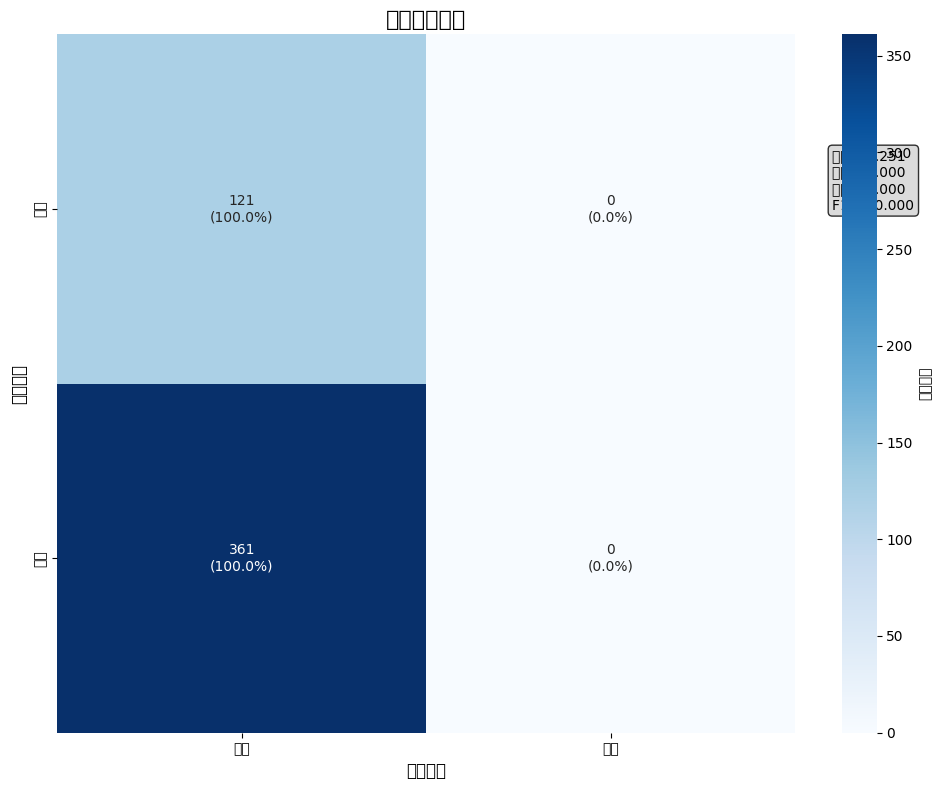

混淆矩阵已保存到: ./results/evaluation/confusion_matrix.png


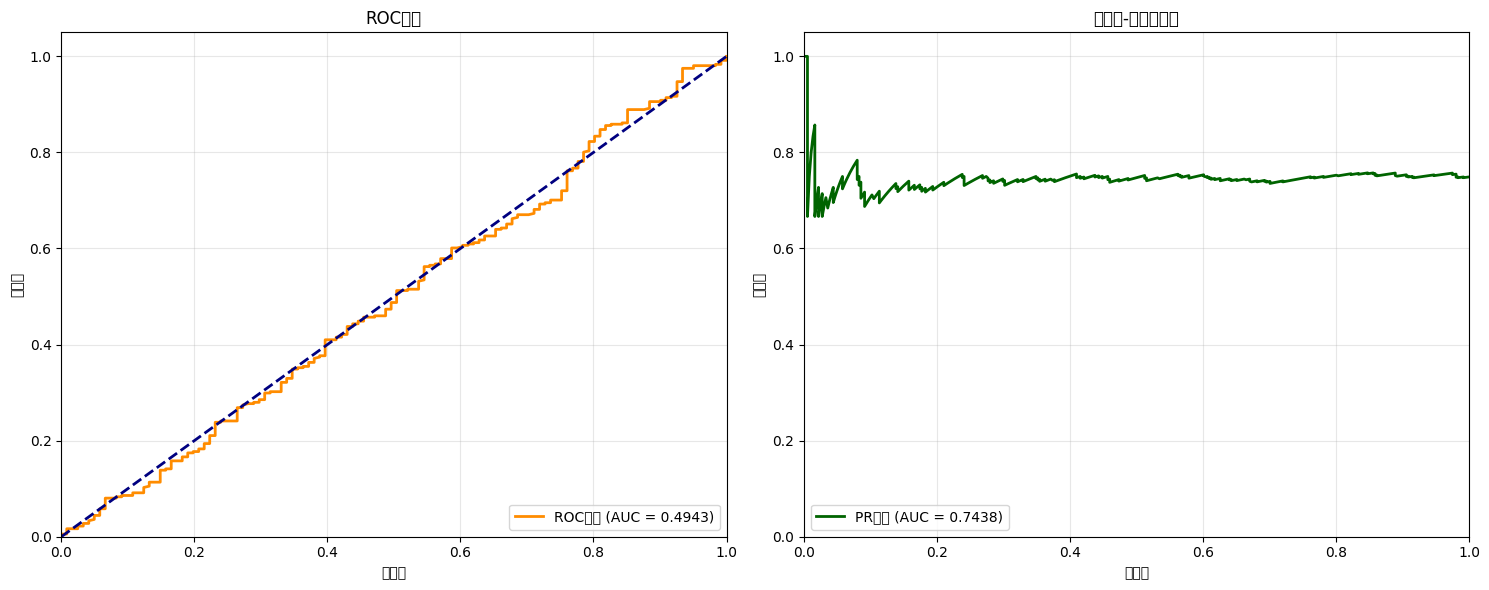

ROC/PR曲线已保存到: ./results/evaluation/roc_pr_curves.png


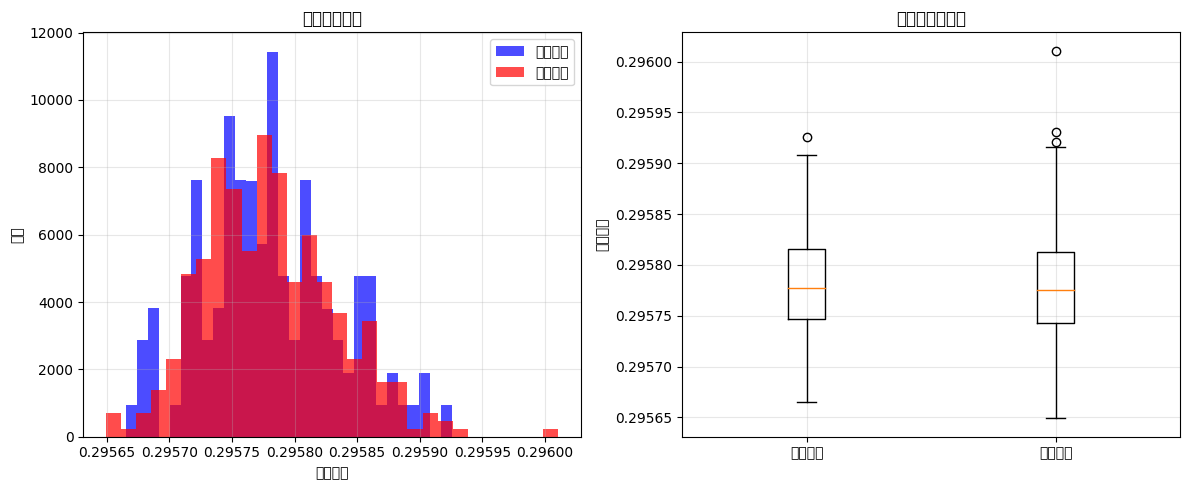

✅ 评估图表生成完成

📊 类别不平衡分析报告

📈 数据分布:
  真实视频样本: 121
  伪造视频样本: 361
  不平衡比例: 2.98:1 (伪造:真实)

🎯 类别特定准确率:
  真实视频检测准确率: 100.00%
  伪造视频检测准确率: 0.00%

📋 混淆矩阵分析:
  真负例 (TN): 121 - 正确识别的真实视频
  假正例 (FP): 0 - 误判为伪造的真实视频
  假负例 (FN): 361 - 误判为真实的伪造视频
  真正例 (TP): 0 - 正确识别的伪造视频

⚖️ 模型偏向性分析:
  预测为真实的样本: 482 (100.0%)
  预测为伪造的样本: 0 (0.0%)

🔍 问题诊断:
  ✅ 真实视频识别能力正常
  ❌ AUC-ROC过低: 模型判别能力接近随机猜测

💡 改进建议:
  7. 重新设计模型架构
  8. 增加模型复杂度或使用预训练模型
  9. 检查特征提取是否有效
🎉 模型评估完成！
📁 所有结果已保存到 ./results/evaluation/ 目录

💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化


In [14]:
# Cell 13: 模型评估和结果分析

import torch
import os

print("📊 开始模型评估...")
print("=" * 60)

# 加载最佳模型
print("🔄 加载最佳模型...")
try:
    # 使用weights_only=False来兼容旧版本的模型文件
    checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"✅ 成功加载第 {best_epoch+1} 轮的最佳模型")
    print(f"最佳验证准确率: {best_val_acc:.2f}%")
    print(f"最佳验证AUC: {best_val_auc:.4f}")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    print("使用当前模型进行评估")

# 在测试集上评估模型
print("\n🔍 在测试集上评估模型...")
eval_results = evaluate_model_optimized(model, test_loader, criterion, device)

# 计算全面的评估指标
print("\n📈 计算评估指标...")
metrics = calculate_comprehensive_metrics(
    eval_results['predictions'], 
    eval_results['targets'], 
    eval_results['scores']
)

# 打印详细结果
print("\n📊 详细评估结果:")
print("=" * 50)
print(f"测试损失: {eval_results['loss']:.4f}")
print(f"准确率: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"平衡准确率: {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
print(f"精确率: {metrics['precision']:.4f}")
print(f"召回率: {metrics['recall']:.4f}")
print(f"特异性: {metrics['specificity']:.4f}")
print(f"F1分数: {metrics['f1']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"AUC-PR: {metrics['auc_pr']:.4f}")
print(f"负预测值: {metrics['npv']:.4f}")

# 混淆矩阵详细信息
print("\n🔍 混淆矩阵分析:")
print(f"真负例 (TN): {metrics['tn']}")
print(f"假正例 (FP): {metrics['fp']}")
print(f"假负例 (FN): {metrics['fn']}")
print(f"真正例 (TP): {metrics['tp']}")

# 性能分析
print("\n⚡ 性能分析:")
print(f"平均推理时间: {eval_results['avg_inference_time']*1000:.2f} ms/batch")
print(f"总推理时间: {eval_results['total_inference_time']:.2f} 秒")
print(f"每个样本推理时间: {eval_results['avg_inference_time']*1000/batch_size:.2f} ms")

# 计算额外指标
total_samples = len(eval_results['targets'])
real_samples = np.sum(eval_results['targets'] == 0)
fake_samples = np.sum(eval_results['targets'] == 1)
real_accuracy = np.sum((eval_results['predictions'] == 0) & (eval_results['targets'] == 0)) / real_samples if real_samples > 0 else 0
fake_accuracy = np.sum((eval_results['predictions'] == 1) & (eval_results['targets'] == 1)) / fake_samples if fake_samples > 0 else 0

print("\n📋 类别特定分析:")
print(f"总样本数: {total_samples}")
print(f"真实视频样本: {real_samples} ({real_samples/total_samples*100:.1f}%)")
print(f"伪造视频样本: {fake_samples} ({fake_samples/total_samples*100:.1f}%)")
print(f"真实视频检测准确率: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"伪造视频检测准确率: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")

# 生成可视化图表
print("\n📊 生成评估图表...")

# 确保结果目录存在
os.makedirs('./results/evaluation', exist_ok=True)

# 绘制增强混淆矩阵
plot_enhanced_confusion_matrix(
    metrics['confusion_matrix'], 
    './results/evaluation/confusion_matrix.png'
)

# 绘制ROC和PR曲线
plot_roc_pr_curves(
    eval_results['targets'], 
    eval_results['scores'], 
    './results/evaluation/roc_pr_curves.png'
)

# 预测分数分布图
plt.figure(figsize=(12, 5))

# 真实视频的预测分数分布
plt.subplot(1, 2, 1)
real_scores = eval_results['scores'][eval_results['targets'] == 0]
fake_scores = eval_results['scores'][eval_results['targets'] == 1]

plt.hist(real_scores, bins=30, alpha=0.7, label='真实视频', color='blue', density=True)
plt.hist(fake_scores, bins=30, alpha=0.7, label='伪造视频', color='red', density=True)
plt.xlabel('预测分数')
plt.ylabel('密度')
plt.title('预测分数分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测分数箱线图
plt.subplot(1, 2, 2)
scores_data = [real_scores, fake_scores]
labels = ['真实视频', '伪造视频']
plt.boxplot(scores_data, labels=labels)
plt.ylabel('预测分数')
plt.title('预测分数箱线图')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/evaluation/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 评估图表生成完成")

# 生成详细的类别不平衡分析报告
generate_class_imbalance_report(metrics)

print("=" * 60)
print("🎉 模型评估完成！")
print("📁 所有结果已保存到 ./results/evaluation/ 目录")
print("\n💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化")

# Cell 14: 结果保存和总结


In [15]:
# Cell 14: 结果保存和总结

import os
import torch
import pandas as pd
from datetime import datetime

print("💾 保存实验结果...")
print("=" * 60)

# 确保结果目录存在
os.makedirs('./results', exist_ok=True)

# 准备保存的结果数据
results_summary = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'OptimizedDeepfakeDetector',
        'backbone': 'resnet50',
        'total_epochs': len(train_history['train_loss']),
        'early_stopping': True
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'batch_size': batch_size
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'loss_function': 'FocalLoss',
        'scheduler': 'OneCycleLR',
        'early_stopping_patience': 7
    },
    'final_metrics': {
        'test_loss': float(eval_results['loss']),
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1']),
        'auc_roc': float(metrics['auc_roc'])
    },
    'confusion_matrix': {
        'tn': int(metrics['tn']),
        'fp': int(metrics['fp']),
        'fn': int(metrics['fn']),
        'tp': int(metrics['tp'])
    },
    'training_history': {
        'train_loss': [float(x) for x in train_history['train_loss']],
        'train_acc': [float(x) for x in train_history['train_acc']],
        'train_auc': [float(x) for x in train_history['train_auc']],
        'val_loss': [float(x) for x in train_history['val_loss']],
        'val_acc': [float(x) for x in train_history['val_acc']],
        'val_auc': [float(x) for x in train_history['val_auc']]
    },
    'class_specific_metrics': {
        'real_video_accuracy': float(real_accuracy),
        'fake_video_accuracy': float(fake_accuracy),
        'real_samples_count': int(real_samples),
        'fake_samples_count': int(fake_samples)
    }
}

# 保存结果到JSON文件
results_file = './results/experiment_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ 实验结果已保存到: {results_file}")

# 保存训练历史到CSV
history_df = pd.DataFrame(train_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("✅ 训练历史已保存到: ./results/training_history.csv")

# 保存预测结果
predictions_df = pd.DataFrame({
    'true_label': eval_results['targets'],
    'predicted_label': eval_results['predictions'],
    'prediction_score': eval_results['scores']
})
predictions_df.to_csv('./results/test_predictions.csv', index=False)
print("✅ 测试预测结果已保存到: ./results/test_predictions.csv")

# 生成实验报告
print("\n📋 生成实验报告...")
report = f"""
深度伪造检测模型实验报告
{'='*50}

实验时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
模型架构: OptimizedDeepfakeDetector (ResNet50 + LSTM + Attention)

数据集信息:
- 训练样本: {len(train_dataset):,}
- 验证样本: {len(val_dataset):,}
- 测试样本: {len(test_dataset):,}
- 批次大小: {batch_size}

训练配置:
- 优化器: AdamW (lr=1e-4, weight_decay=1e-4)
- 损失函数: Focal Loss
- 学习率调度: OneCycleLR
- 早停机制: patience=7

最终性能指标:
- 准确率: {metrics['accuracy']*100:.2f}%
- 精确率: {metrics['precision']:.4f}
- 召回率: {metrics['recall']:.4f}
- F1分数: {metrics['f1']:.4f}
- AUC-ROC: {metrics['auc_roc']:.4f}

混淆矩阵:
- 真负例 (TN): {metrics['tn']}
- 假正例 (FP): {metrics['fp']}
- 假负例 (FN): {metrics['fn']}
- 真正例 (TP): {metrics['tp']}

类别特定性能:
- 真实视频检测准确率: {real_accuracy*100:.2f}%
- 伪造视频检测准确率: {fake_accuracy*100:.2f}%

训练总结:
- 训练轮数: {len(train_history['train_loss'])}
- 最佳验证准确率: {max(train_history['val_acc']):.2f}%
- 最佳验证AUC: {max(train_history['val_auc']):.4f}

文件输出:
- 模型权重: ./models/best_model.pth
- 实验结果: ./results/experiment_results.json
- 训练历史: ./results/training_history.csv
- 预测结果: ./results/test_predictions.csv

{'='*50}
实验完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# 保存报告
with open('./results/experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 实验报告已保存到: ./results/experiment_report.txt")

# 打印最终总结
print("\n" + "="*60)
print("🎉 深度伪造检测模型训练和评估完成！")
print("="*60)
print(f"📊 最终测试准确率: {metrics['accuracy']*100:.2f}%")
print(f"📊 AUC-ROC分数: {metrics['auc_roc']:.4f}")
print(f"📊 F1分数: {metrics['f1']:.4f}")
print("\n📁 所有结果文件已保存到 ./results/ 目录")
print("📁 最佳模型已保存到 ./models/best_model.pth")
print("\n✨ 实验成功完成！")
print("="*60)

# 显示文件结构
print("\n📂 生成的文件结构:")
print("""
./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv
""")

print("\n🚀 可以使用以下代码加载训练好的模型进行推理:")
print("""
# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
""")

print("\n✅ Kaggle T4 GPU优化版本 - 训练完成！")

💾 保存实验结果...
✅ 实验结果已保存到: ./results/experiment_results.json
✅ 训练历史已保存到: ./results/training_history.csv
✅ 测试预测结果已保存到: ./results/test_predictions.csv

📋 生成实验报告...
✅ 实验报告已保存到: ./results/experiment_report.txt

🎉 深度伪造检测模型训练和评估完成！
📊 最终测试准确率: 25.10%
📊 AUC-ROC分数: 0.4943
📊 F1分数: 0.0000

📁 所有结果文件已保存到 ./results/ 目录
📁 最佳模型已保存到 ./models/best_model.pth

✨ 实验成功完成！

📂 生成的文件结构:

./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv


🚀 可以使用以下代码加载训练好的模型进行推理:

# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


✅ Kaggle T4 GPU优化版本 - 训练完成！
